In [69]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from pathlib import Path
from matplotlib import pyplot as plt
import matplotlib as mpl
# remove top and right axis from plots
# mpl.rcParams["axes.spines.right"] = False
# mpl.rcParams["axes.spines.top"] = False

# remove all edges
mpl.rcParams["axes.edgecolor"] = "none"

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

mpl.rc('font', **font)

In [6]:
def get_log_probs(event_path):
    event_acc = EventAccumulator(str(event_path))
    event_acc.Reload()
    # print(event_acc.Tags()) # Show all tags in the log file

    _, step_nums, training_log_probs = zip(*event_acc.Scalars('training_log_probs'))
    _, _, validation_log_probs = zip(*event_acc.Scalars('validation_log_probs'))
    _, _, best_validation_log_prob = zip(*event_acc.Scalars('best_validation_log_prob'))
    return step_nums, training_log_probs, validation_log_probs, best_validation_log_prob

In [7]:
!pwd

/home/wehe/tmp/NSC/codes/notebook


In [8]:
ls ../src/train/logs

log-test/  logs_L0_v1/  logs_L0_v1_/  train_L0_rnn/


In [13]:
train_id = 6
# the log path
log_dir = Path('../src/train/logs')
event_path = log_dir / 'train_L0_rnn'/ 'a0' / \
             'events.out.tfevents.1680572132.snnmonster.1688304.0'
# title=f'log_sample_Rchoice{train_id}'

# log_dir = Path('../src/train/logs')
# event_path = log_dir / 'logs_15_p1' / f'log_test' / \
#              'events.out.tfevents.1678642099.snnmonster.3800478.0'
title=f'log_a0'

event_acc = EventAccumulator(str(event_path))
event_acc.Reload()
event_acc.Scalars('training_log_probs')

[ScalarEvent(wall_time=1680572365.1837993, step=0, value=-13.562552452087402),
 ScalarEvent(wall_time=1680572365.1838932, step=1, value=-12.628090858459473),
 ScalarEvent(wall_time=1680572365.183982, step=2, value=-11.721181869506836),
 ScalarEvent(wall_time=1680572365.1840754, step=3, value=-11.087596893310547),
 ScalarEvent(wall_time=1680572365.184166, step=4, value=-10.742319107055664),
 ScalarEvent(wall_time=1680572365.184263, step=5, value=-10.483850479125977),
 ScalarEvent(wall_time=1680572365.1843474, step=6, value=-10.344585418701172),
 ScalarEvent(wall_time=1680572365.1844387, step=7, value=-10.13659381866455),
 ScalarEvent(wall_time=1680572365.1845374, step=8, value=-10.071606636047363),
 ScalarEvent(wall_time=1680572365.1846266, step=9, value=-9.96740436553955),
 ScalarEvent(wall_time=1680572365.1847177, step=10, value=-9.906285285949707),
 ScalarEvent(wall_time=1680572365.1848075, step=11, value=-9.827425003051758),
 ScalarEvent(wall_time=1680572365.1849, step=12, value=-9.

In [37]:
runs = [141, 71, 76, 222, 80, 48, 97, 106, 32, 58]
run_collect = []
run_sum = 0
for run in runs:
    run_sum += run
    run_collect.append(run_sum)
run_collect
valid_prob_collect = [validation_log_probs[run-1] for run in run_collect]

In [38]:
valid_prob_collect

[-8.644941329956055,
 -0.44466060400009155,
 -0.29072582721710205,
 -0.131118044257164,
 -0.1479990929365158,
 -0.19152110815048218,
 -0.15503273904323578,
 -0.18480302393436432,
 -0.19767162203788757,
 -0.16091156005859375]

(-11.0, 1.0)

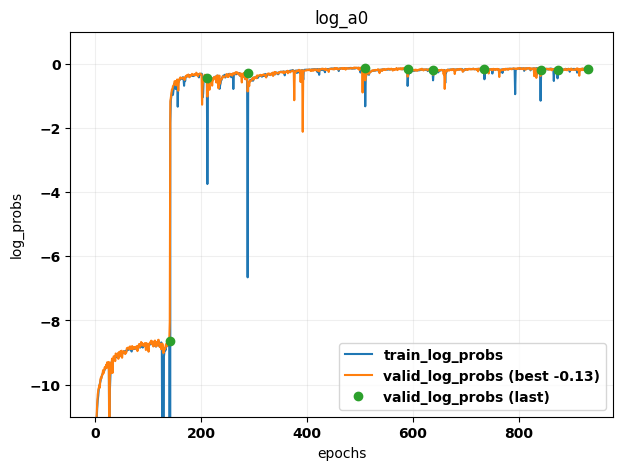

In [40]:
step_nums, training_log_probs, validation_log_probs, best_validation_log_prob = get_log_probs(event_path)
best_validation_log_prob = max(training_log_probs)

fig, ax = plt.subplots(figsize=(7,5))
plt.plot(step_nums, training_log_probs, label='train_log_probs')
plt.plot(step_nums, validation_log_probs, label=f'valid_log_probs (best {best_validation_log_prob:.2f})')
plt.plot(run_collect, valid_prob_collect, 'o', label='valid_log_probs (last)')
plt.legend()
plt.title(title)
plt.xlabel('epochs')
plt.ylabel('log_probs')
plt.grid(alpha=0.2)
plt.ylim([-11, 1])

(-1.0, 0.3)

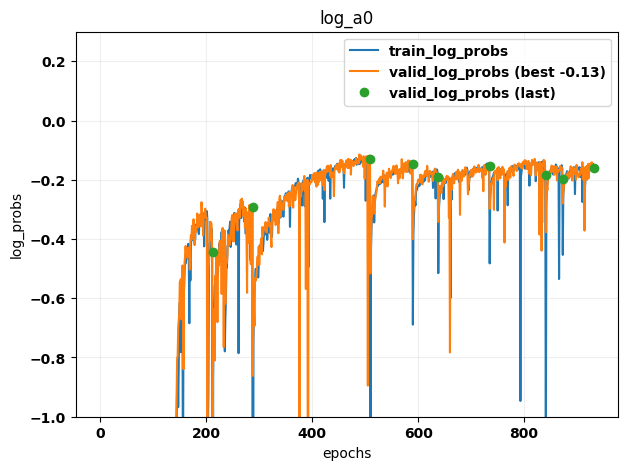

In [44]:
step_nums, training_log_probs, validation_log_probs, best_validation_log_prob = get_log_probs(event_path)
best_validation_log_prob = max(training_log_probs)

fig, ax = plt.subplots(figsize=(7,5))
plt.plot(step_nums, training_log_probs, label='train_log_probs')
plt.plot(step_nums, validation_log_probs, label=f'valid_log_probs (best {best_validation_log_prob:.2f})')
plt.plot(run_collect, valid_prob_collect, 'o', label='valid_log_probs (last)')
plt.legend()
plt.title(title)
plt.xlabel('epochs')
plt.ylabel('log_probs')
plt.grid(alpha=0.2)
plt.ylim([-1, 0.3])

In [53]:
import sys
sys.path.append('../src')
import os
os.chdir('../')

In [56]:
from dataset.get_xo import get_xo
from config.load_config import load_config
config = load_config(
    config_simulator_path=Path('./src/config') / 'test' / 'test_simulator.yaml',
    config_dataset_path=Path('./src/config') / 'test' / 'test_dataset.yaml',
    config_train_path=Path('./src/config') / 'test' / 'test_train.yaml',
)

In [57]:
x_o = get_xo(
        subject_id          = config['x_o']['subject_id'],
        chosen_dur_list     = config['x_o']['chosen_dur_list'],
        chosen_MS_list      = config['x_o']['chosen_MS_list'],
        seqC_sample_per_MS     = config['x_o']['seqC_sample_per_MS'],
        trial_data_path     = config['x_o']['trial_data_path'],
        
        seqC_process_method = config['dataset']['seqC_process'],
        nan2num             = config['dataset']['nan2num'],
        summary_type        = config['dataset']['summary_type'],
    )


---
x_o information
x_o.shape:  (2100, 16)
subject_id:  2
chosen_dur_list:  [9]
chosen_MS_list:  [0.2, 0.4, 0.8]
seqC_sample_per_MS:  700


In [59]:
x_o.shape

(2100, 16)

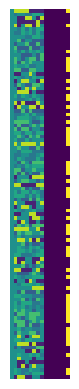

In [82]:
for i in range(21):
    img = plt.imshow(x_o[i*100:(i+1)*100,:])
    plt.axis('off')
    plt.savefig(f'./src/train/logs/train_L0_rnn/a0/x_o/x_o_{i}.png', bbox_inches='tight', pad_inches=0)

/home/wehe/anaconda3/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  


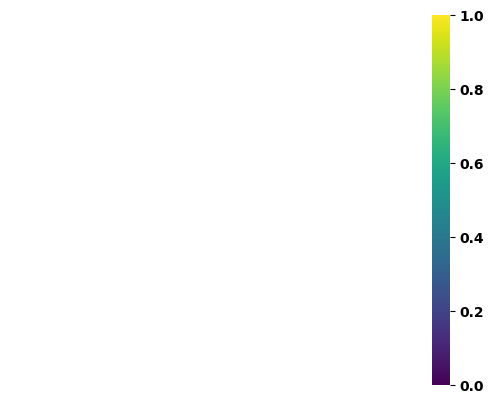

In [78]:
plt.axis('off')
plt.colorbar(img)